In [1]:
import tweepy
import matplotlib.pyplot as plt
import string
import nltk
import Sastrawi
import numpy as np
import pandas as pd
import ast
import os
import re
import csv
import seaborn as sns

from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
api_key = "qubRP6d5B5eCD3RHrgoMRkDjH"
api_secret_key = "AJlk1MiHfXqnhByWtCf1Mbi2T9WGW08hoLkkDIbks4ztUpFx99"
access_token ="3180202308-DmrgiSoxUUoSRevLLPldgCE57M0eD117K0mhFG5"
access_token_secret = "fuY5Hkk838OnmGOZUb16KLkSDw3JZjflxXQ1NHP6pP9Jr"

In [3]:
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret) 
API = tweepy.API(auth, wait_on_rate_limit = False)

In [9]:
posts = tweepy.Cursor(API.search_tweets, q='shopeefood -filter:retweets', tweet_mode='extended', lang='id').items(100)

In [10]:
users = [[tweet.created_at, tweet.full_text] for tweet in posts]
users

[[datetime.datetime(2021, 12, 27, 3, 49, 43, tzinfo=datetime.timezone.utc),
  'Ganteng banget Soobin https://t.co/ieFhTiOcEV'],
 [datetime.datetime(2021, 12, 27, 3, 47, 15, tzinfo=datetime.timezone.utc),
  '@MOANAmenfess Pertama kali liat foto ini, kepo bgt sama soobin tapi yg akhirnya jadi bias ku ya yeonjun hehe @TXT_members https://t.co/jfp88Ph5dg'],
 [datetime.datetime(2021, 12, 27, 3, 46, 32, tzinfo=datetime.timezone.utc),
  '@awrorrar Nder kalo up, boleh tag aku ga ,makasi bestie 🥰🥰'],
 [datetime.datetime(2021, 12, 27, 3, 45, 4, tzinfo=datetime.timezone.utc),
  'SHARING WJSN OFFICIAL FANMEETING &lt;WJ STAND-BY&gt;  \n\nMEMBER SET (PC, POSTCARD, FILM PHOTO)\nMEMBER A (80K, DP 50K)\n✅ SEOLA\n✅ BOLA\n✅ LUDA \n✅ EUNSEO\nMEMBER B (75K, DP 45K)\n✅ EXY\n✅ YEOREUM \nMEMBER C (70K, DP 40K)\n✅ SOOBIN\n✅ DAWON\n✅ DAYOUNG\n✅ YEONJUNG \n\nMember A WAJIB pair. https://t.co/roVnS5q3am'],
 [datetime.datetime(2021, 12, 27, 3, 44, 53, tzinfo=datetime.timezone.utc),
  '@eydot95 I can feel also sinc

In [6]:
df = pd.DataFrame(data=users, columns=['Created_At','Tweets'])

In [7]:
def remove(tweet):
    #lowercasing
    tweet = tweet.lower()
    #remove one char
    tweet = re.sub(r"\b[a-zA-Z]\b", "", tweet)
    #remove number
    tweet = re.sub('[0-9]+', '', tweet)
    # remove tab, new line, ans back slice
    tweet = tweet.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    tweet = tweet.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    tweet = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", tweet).split())
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)   
    #remove punctuation
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #remove whitespace leading & trailing
    tweet = tweet.strip()
    #remove multiple whitespace into single whitespace
    tweet = re.sub('\s+',' ',tweet)
    return tweet

df["Clean_Data"] = df["Tweets"].apply(remove)

In [8]:
normalized_word = pd.read_csv('kebutuhan/Kamus_Baku.csv')
normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return ' '.join([normalized_word_dict[term] if term in normalized_word_dict else term for term in document.split()])

df['Tweet_Normal'] = df['Clean_Data'].apply(normalized_term)

In [9]:
stop_words=stopwords.words('indonesian')
stop_words.extend(["yg", "dg", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh',
                       '&amp', 'yah', 'klau', 'a', 'b', 'c', 'd', 'e', 'f',
                   'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
                   's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

df['Tanpa_StopWords'] = df['Tweet_Normal'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [10]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['Stemming'] = df['Tanpa_StopWords'].apply(lambda x : ([stemmer.stem(y) for y in x.split()]))

In [11]:
df.to_csv("stemming-coba.csv")

In [12]:
df = pd.read_csv("stemming-coba.csv")

In [13]:
df = pd.DataFrame(df[['Tweets', 'Clean_Data', 'Tweet_Normal', 'Tanpa_StopWords', 'Stemming']])

In [14]:
word_dict = {}
for i in range(0,len(df['Stemming'])):
    sentence = df['Stemming'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [15]:
negasi = ['bukan','tidak','ga','gk', 'gak', 'engga']
lexicon = pd.read_csv('kebutuhan/full_lexicon.csv')
lexicon = lexicon.reset_index(drop=True)

In [16]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

ns_words = []

In [17]:
sencol =[]
senrow =np.array([])
nsen = 0

sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Stemming'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [18]:
sencol.append('Bobot')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

df_sen

,suka,coba,daftar,marah,promo,minimal,ganti,balik,mogok,makan,...,resah,tentu,pol,maneh,kabeh,jangka,modal,gede,parsel,Bobot
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,-12
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,11
528,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7
529,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7
530,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,7


In [19]:
cek_df = pd.DataFrame([])
cek_df['Tweetnya'] = df['Stemming'].copy()
cek_df['Bobot']  = df_sen['Bobot'].copy()

cek_df

,Tweetnya,Bobot
0,"['motor', 'suka', 'jalan', 'coba', 'daftar', '...",6
1,"['ih', 'marah', 'promo', 'minimal', 'purcase',...",-12
2,"['shopee', 'bersi', 'shopeefood', 'yaallah', '...",-3
3,"['untung', 'ditrack', 'belanja', 'shopeefood']",5
4,"['nasi', 'beli', 'lauk', 'pakai', 'voucher', '...",14
...,...,...
527,"['jual', 'makan', 'paling', 'jangka', 'modal',...",11
528,"['bagi', 'makan', 'gratis', 'teman', 'shopeefo...",7
529,"['bagi', 'makan', 'gratis', 'teman', 'shopeefo...",7
530,"['sepi', 'kieu', 'order', 'promo', 'area', 'ba...",7


In [20]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

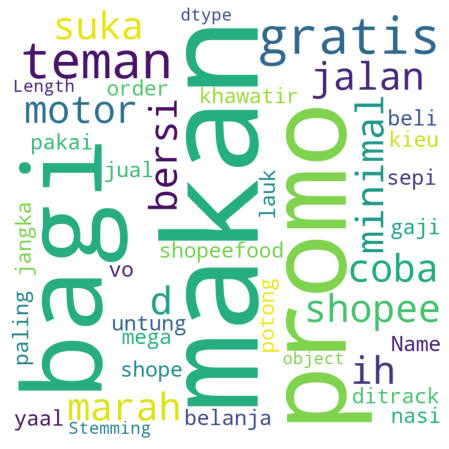

In [21]:
word_to_plot = df['Stemming'].copy()
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', max_words = 1000
                      , min_font_size = 20, collocations=False).generate(str(word_to_plot_1))

#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [22]:
df_sen.describe()

,suka,coba,daftar,marah,promo,minimal,ganti,balik,mogok,makan,...,resah,tentu,pol,maneh,kabeh,jangka,modal,gede,parsel,Bobot
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.009398,0.033835,0.009398,0.005639,0.067669,0.028195,0.005639,0.001880,0.001880,0.353383,...,0.001880,0.001880,0.001880,0.001880,0.001880,0.001880,0.001880,0.001880,0.001880,3.947368
std,0.096580,0.191096,0.096580,0.096873,0.279776,0.187043,0.074952,0.043355,0.043355,0.497761,...,0.043355,0.043355,0.043355,0.043355,0.043355,0.043355,0.043355,0.043355,0.043355,5.303328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,1.000000,2.000000,1.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000


In [23]:
df['Bobot'] = df_sen['Bobot']

In [24]:
df.loc[df['Bobot'] == 0, 'Label'] = 'Netral'
df.loc[df['Bobot'] > 0, 'Label'] = 'Positif'
df.loc[df['Bobot'] < 0, 'Label'] = 'Negatif'

In [25]:
df['Label'].value_counts()

Positif    391
Negatif     92
Netral      49
Name: Label, dtype: int64

In [26]:
df.loc[cek_df['Bobot'] == 0, 'Sentimen'] = 1 #netral
df.loc[cek_df['Bobot'] > 0, 'Sentimen'] = 2 #positive
df.loc[cek_df['Bobot'] < 0, 'Sentimen'] = 0 #negative

In [27]:
df

,Tweets,Clean_Data,Tweet_Normal,Tanpa_StopWords,Stemming,Bobot,Label,Sentimen
0,@definitelyjulid kalo ada motor dan suka jalan...,kalo ada motor dan suka jalan coba daftar shop...,kalau ada motor dan suka jalan coba daftar sho...,motor suka jalan coba daftar shopeefood,"['motor', 'suka', 'jalan', 'coba', 'daftar', '...",6,Positif,2.0
1,ih marah bgt skrg udah gada promo 60% min purc...,ih marah bgt skrg udah gada promo min purcase ...,ih marah begitu sekarang sudah tidak ada promo...,ih marah promo minimal purcase rb id diganti m...,"['ih', 'marah', 'promo', 'minimal', 'purcase',...",-12,Negatif,0.0
2,ini shopee gamau bikin bersi shopeefood apa ya...,ini shopee gamau bikin bersi shopeefood apa ya...,ini shopee tidak mau bikin bersi shopeefood ap...,shopee bersi shopeefood yaallah pingsan,"['shopee', 'bersi', 'shopeefood', 'yaallah', '...",-3,Negatif,0.0
3,"Untung yang di-track cuma belanja, bukan Shope...",untung yang ditrack cuma belanja bukan shopeefood,untung yang ditrack hanya belanja bukan shopee...,untung ditrack belanja shopeefood,"['untung', 'ditrack', 'belanja', 'shopeefood']",5,Positif,2.0
4,@collegemenfess masak nasi sendiri. beli lauk ...,masak nasi sendiri beli lauk pakai voucher sho...,masa nasi sendiri beli lauk pakai voucher shop...,nasi beli lauk pakai voucher shopeefood zaman ...,"['nasi', 'beli', 'lauk', 'pakai', 'voucher', '...",14,Positif,2.0
...,...,...,...,...,...,...,...,...
527,"@Askrlfess Jual makan sih palingan, yang bisa ...",jual makan sih palingan yang bisa jangka panja...,jual makan sih palingan yang bisa jangka panja...,jual makan palingan jangka modal jual igfb ram...,"['jual', 'makan', 'paling', 'jangka', 'modal',...",11,Positif,2.0
528,Share &amp; Makan Gratis Bareng Teman di Shope...,share amp makan gratis bareng teman di shopeefood,bagikan amp makan gratis bersama teman di shop...,bagikan makan gratis teman shopeefood,"['bagi', 'makan', 'gratis', 'teman', 'shopeefo...",7,Positif,2.0
529,Share &amp; Makan Gratis Bareng Teman di Shope...,share amp makan gratis bareng teman di shopeefood,bagikan amp makan gratis bersama teman di shop...,bagikan makan gratis teman shopeefood,"['bagi', 'makan', 'gratis', 'teman', 'shopeefo...",7,Positif,2.0
530,Sepi kieu orderan padahal promo 70%.yang area ...,sepi kieu orderan padahal promo yang area band...,sepi kieu orderan padahal promo yang area band...,sepi kieu orderan promo area bandung ayo order...,"['sepi', 'kieu', 'order', 'promo', 'area', 'ba...",7,Positif,2.0


Text(0.5, 0, 'sentiment')

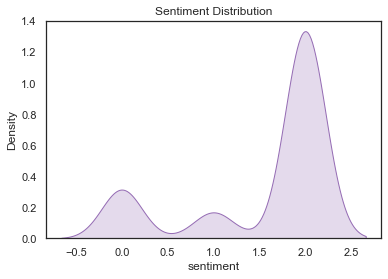

In [28]:
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(df['Sentimen'],color='m',shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

In [29]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(df['Stemming'], df['Sentimen'], test_size=0.1, random_state=0)
train_df = pd.DataFrame()
train_df['Stemming'] = x_train
train_df['Sentimen'] = y_train
test_df = pd.DataFrame()
test_df['Stemming'] = x_test
test_df['Sentimen'] = y_test

In [30]:
tfidf = TfidfVectorizer()  
docs = df['Stemming']
x = tfidf.fit(docs)
x_train_tfidf = x.transform(x_train)
x_test_tfidf = x.transform(x_test)

In [31]:
SVM = svm.SVC(kernel='linear')

In [32]:
y_pred = SVM.fit(x_train_tfidf, y_train).predict(x_test_tfidf)
cm = metrics.confusion_matrix(y_test, y_pred)

In [33]:
word_tfidf = tfidf.fit_transform(df['Stemming'].values)

In [34]:
df['Sentimen'] = SVM.predict(word_tfidf)

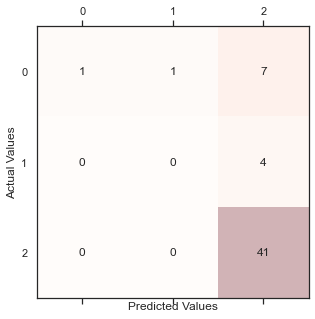

              precision    recall  f1-score   support

         0.0       1.00      0.11      0.20         9
         1.0       0.00      0.00      0.00         4
         2.0       0.79      1.00      0.88        41

    accuracy                           0.78        54
   macro avg       0.60      0.37      0.36        54
weighted avg       0.77      0.78      0.70        54



In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(y_test, y_pred))

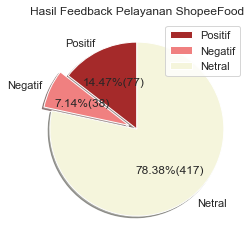

In [36]:
values = df['Stemming'].groupby(df['Sentimen']).count().values
explode = [0, 0.1, 0]
labels = ['Positif', 'Negatif', 'Netral']
colors = ['brown', 'lightcoral', 'beige']

def make_autopct(values):
    def my_autopct(pct):
        total  = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(values, colors=colors, labels=labels, explode=explode,
      autopct=make_autopct(values), shadow=True, startangle=90)
plt.legend()
plt.title("Hasil Feedback Pelayanan ShopeeFood")
plt.show()